# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
print(d.describe())

           height      weight         age        male
count  352.000000  352.000000  352.000000  352.000000
mean   154.597093   44.990486   41.138494    0.468750
std      7.742332    6.456708   15.967855    0.499733
min    136.525000   31.071052   18.000000    0.000000
25%    148.590000   40.256290   28.000000    0.000000
50%    154.305000   44.792210   39.000000    0.000000
75%    160.655000   49.292693   51.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000


## Task 1. Prior predictive checks

In [4]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [5]:
sim_df = sim.draws_pd()

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'height'}>, <AxesSubplot:>]],
      dtype=object)

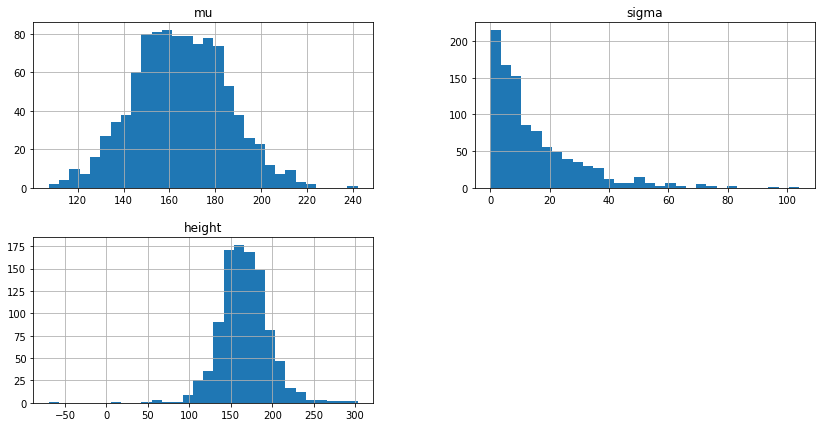

In [6]:
sim_df.hist(column=['mu', 'sigma', 'height'], figsize=(14, 7), bins=30)

array([[<AxesSubplot:title={'center':'x'}>]], dtype=object)

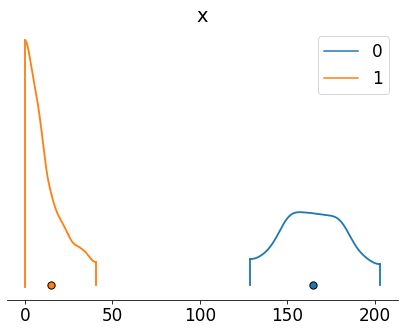

In [7]:
az.plot_density([sim_df['mu'].to_numpy(), sim_df['sigma'].to_numpy()], figsize = (7, 5))

In [8]:
sim_df.describe()

,lp__,accept_stat__,mu,sigma,height
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,164.862189,14.675587,165.947759
std,0.0,0.0,20.247974,14.720688,30.599447
min,0.0,0.0,107.393000,0.028517,-69.590100
25%,0.0,0.0,150.599750,4.301872,147.109500
50%,0.0,0.0,164.702000,9.650560,165.573500
75%,0.0,0.0,179.062500,20.712550,183.545000
max,0.0,0.0,241.986000,103.987000,302.987000


## Task 2. Model fit and evaluation

In [9]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


In [11]:
fit_df = fit.draws_pd()

array([[<AxesSubplot:title={'center':'x'}>]], dtype=object)

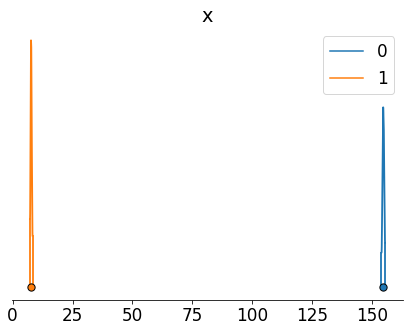

In [12]:
az.plot_density([fit_df['mu'].to_numpy(), fit_df['sigma'].to_numpy()], figsize = (7, 5))

Text(0.5, 1.0, 'predicted heights')

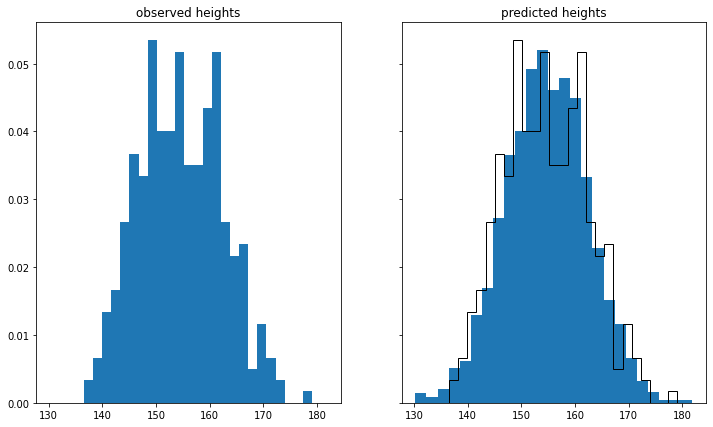

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)
axs[0].hist(d.height, bins=25, density=True)
axs[0].set_title('observed heights')

axs[1].hist(fit.stan_variable('height'), bins=25, density=True)
axs[1].hist(d.height, bins=25, histtype='step', color='black', density=True)
axs[1].set_title('predicted heights')

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [14]:
d['c_weight'] = d.weight - d.weight.mean()
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041914,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


In [15]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

## Task 4. Prior predictive checks
 

In [16]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [17]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta_')

Text(0, 0.5, 'height')

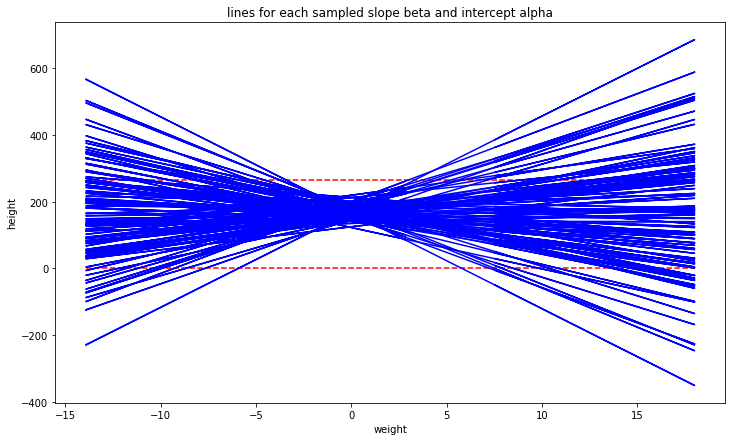

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
axs.hlines([0, 265], xmin=d.c_weight.min(), xmax=d.c_weight.max(), linestyles='--', color='r')
for i in range(100):
    axs.plot(d.c_weight, alpha_sim[i] + beta_sim[i] * d.c_weight, color='blue')
axs.set_title("lines for each sampled slope beta and intercept alpha")
axs.set_xlabel("weight")
axs.set_ylabel("height")

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [19]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [20]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [21]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta_')

Text(0, 0.5, 'height')

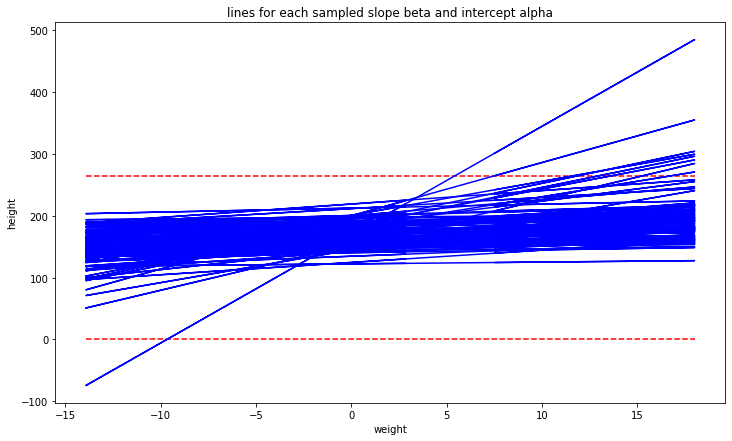

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
axs.hlines([0, 265], xmin=d.c_weight.min(), xmax=d.c_weight.max(), linestyles='--', color='r')
for i in range(100):
    axs.plot(d.c_weight, alpha_sim[i] + beta_sim[i] * d.c_weight, color='blue')
axs.set_title("lines for each sampled slope beta and intercept alpha")
axs.set_xlabel("weight")
axs.set_ylabel("height")

In [23]:
import seaborn as sns

height_sim = sim.stan_variable('height')
height_size = height_sim.shape[0]

quantiles = [5, 25, 50, 75, 95]

quantile_data = {'5': np.zeros(height_size),
                 '25': np.zeros(height_size),
                 '50': np.zeros(height_size),
                 '75': np.zeros(height_size),
                 '95': np.zeros(height_size),
                 'min': np.zeros(height_size),
                 'max': np.zeros(height_size)}

for i, height_vec in enumerate(height_sim):
    for quantile in quantiles:
        quantile_data[str(quantile)][i] = np.percentile(height_vec, quantile)
    quantile_data['min'][i] = np.min(height_vec)
    quantile_data['max'][i] = np.max(height_vec)


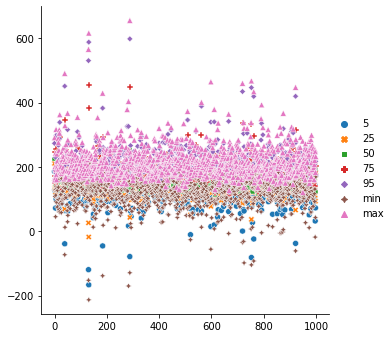

In [24]:
quantilesDf = pd.DataFrame(quantile_data)
sns.relplot(quantilesDf)


Observed data is possible within the prior model

## Task 6. Fitting and evaluating model


In [25]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [26]:
N = 150
d_N = d.head(N)
data_fit = dict(N=len(d_N),
                weight = d_N.weight.values,
                heights = d_N.height.values)

In [27]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)



INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


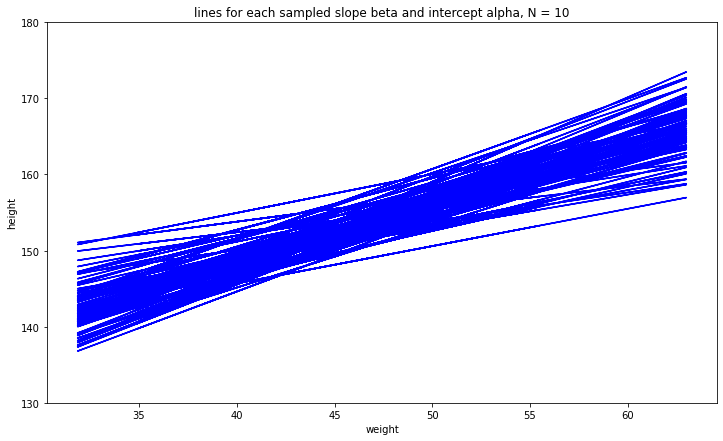

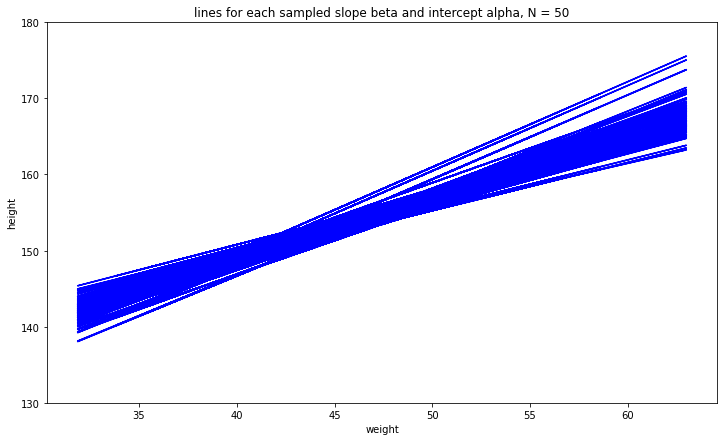

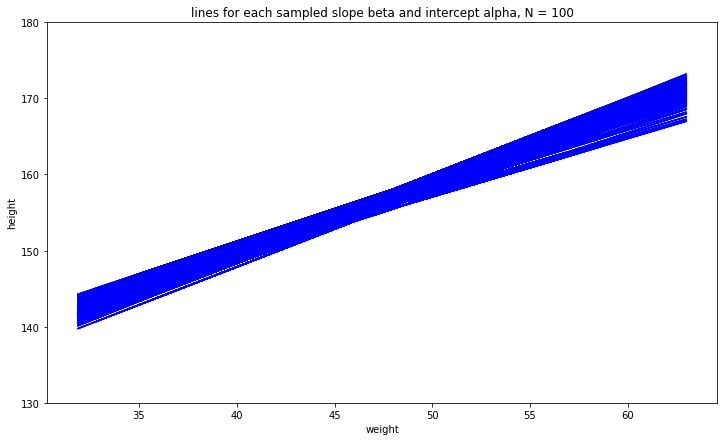

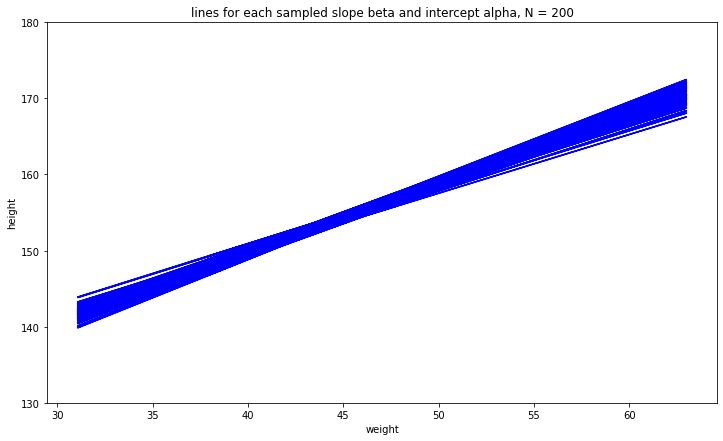

In [28]:
Ns = [10, 50, 100, 200]

for N in Ns:
    d_N = d.head(N)
    data_fit = dict(N=len(d_N),
                    weight = d_N.weight.values,
                    heights = d_N.height.values)

    fit=model_2_fit.sample(data=data_fit,seed=28052020)

    alpha_fit = fit.stan_variable('alpha')
    beta_fit = fit.stan_variable('beta_')
    mu_fit = fit.stan_variable('mu')
    height_pred = fit.stan_variable('height')

    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    for i in range(100):
        axs.plot(d_N.weight, alpha_fit[i] + beta_fit[i] * d_N.weight, color='blue')
        axs.set_title(f"lines for each sampled slope beta and intercept alpha, N = {N}")
        axs.set_xlabel("weight")
        axs.set_ylabel("height")
        axs.set_ylim([130, 180])

As the value of "N" increases, the uncertainty decreases

3. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)





chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


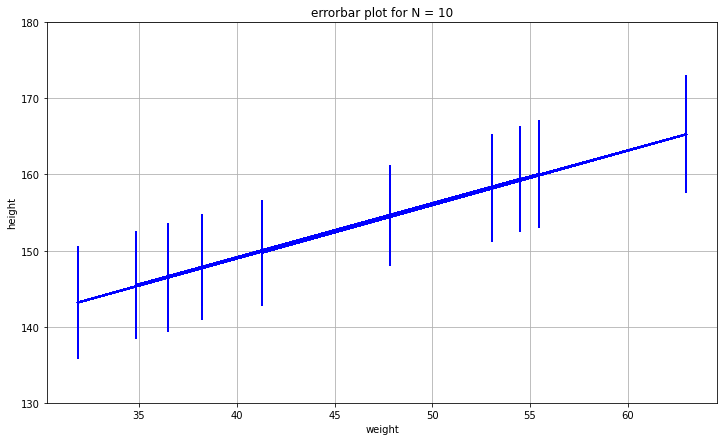

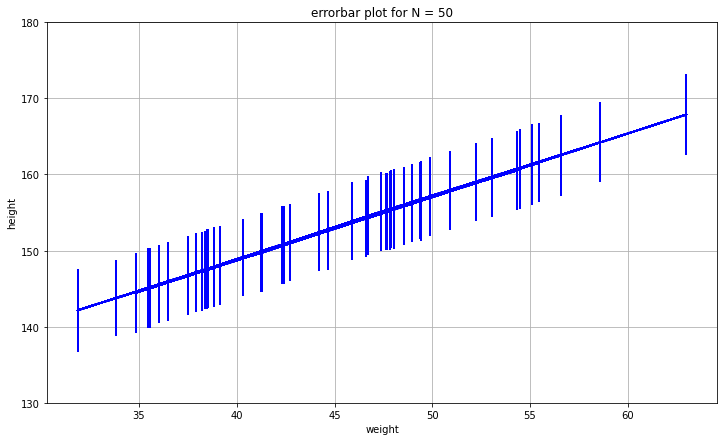

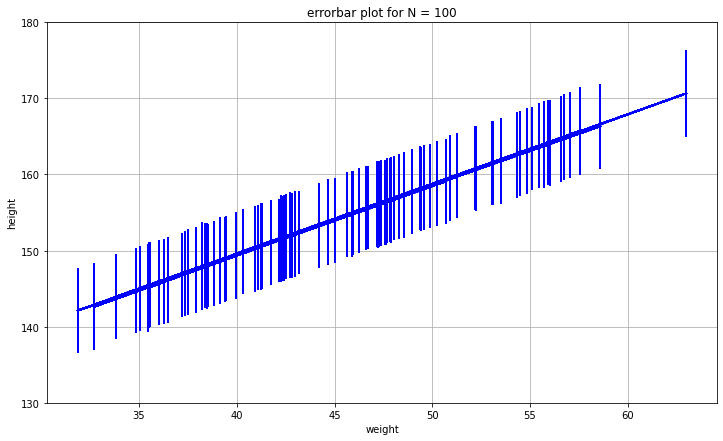

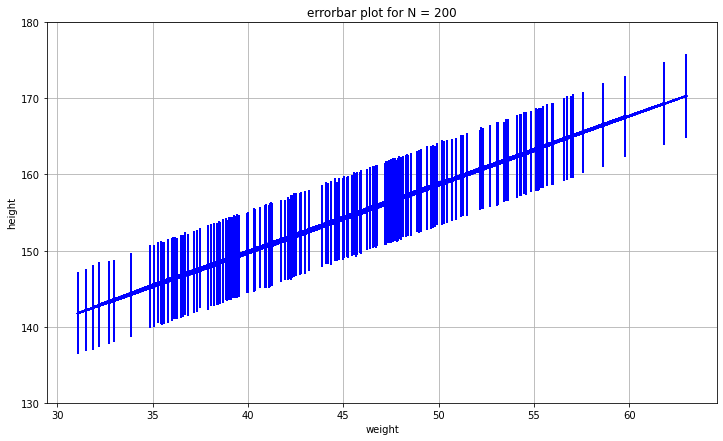

In [29]:
Ns = [10, 50, 100, 200]

for N in Ns:
    d_N = d.head(N)
    data_fit = dict(N=len(d_N),
                    weight = d_N.weight.values,
                    heights = d_N.height.values)

    fit=model_2_fit.sample(data=data_fit,seed=28052020)

    alpha_fit = fit.stan_variable('alpha')
    beta_fit = fit.stan_variable('beta_')
    mu_fit = fit.stan_variable('mu')
    height_pred = fit.stan_variable('height')
    weights = d_N.weight.values

    height_mean = height_pred.mean(axis=0)
    height_std = height_pred.std(axis=0)

    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    for i in range(100):
        axs.errorbar(weights, height_mean, height_std, color='blue')
        axs.set_title(f"errorbar plot for N = {N}")
        axs.set_xlabel("weight")
        axs.set_ylabel("height")
        axs.set_ylim([130, 180])
        axs.grid("on")

Looks like as the value of "N" increases, the errorbar heights decrease

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


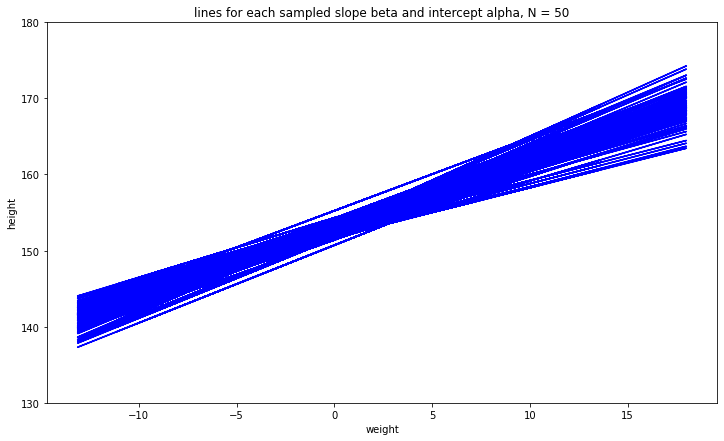

In [30]:
N = 50

d_N = d.head(N)
data_fit = dict(N=len(d_N),
                weight = (d_N.c_weight.values),
                heights = d_N.height.values)

fit=model_2_fit.sample(data=data_fit,seed=28052020)

alpha_fit = fit.stan_variable('alpha')
beta_fit = fit.stan_variable('beta_')
mu_fit = fit.stan_variable('mu')
height_pred = fit.stan_variable('height')

fig, axs = plt.subplots(1, 1, figsize=(12, 7))
for i in range(100):
    axs.plot(d_N.c_weight, alpha_fit[i] + beta_fit[i] * d_N.c_weight, color='blue')
    axs.set_title(f"lines for each sampled slope beta and intercept alpha, N = {N}")
    axs.set_xlabel("weight")
    axs.set_ylabel("height")
    axs.set_ylim([130, 180])

In [31]:
model_2_fit7=CmdStanModel(stan_file='height_2_fit7.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


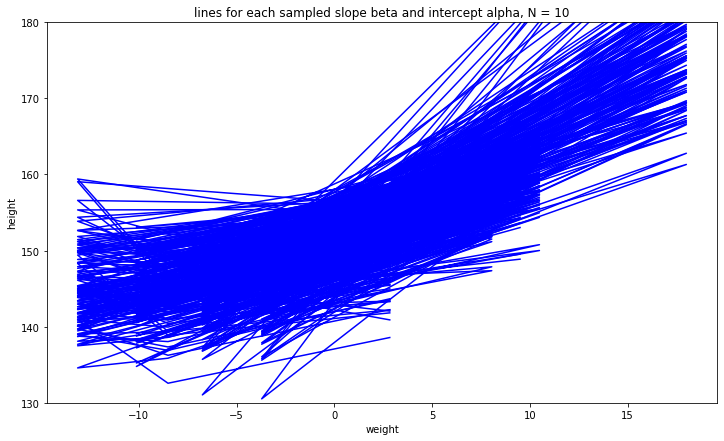

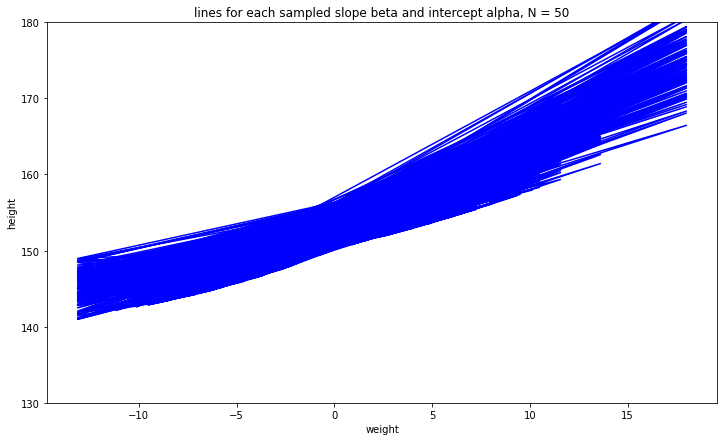

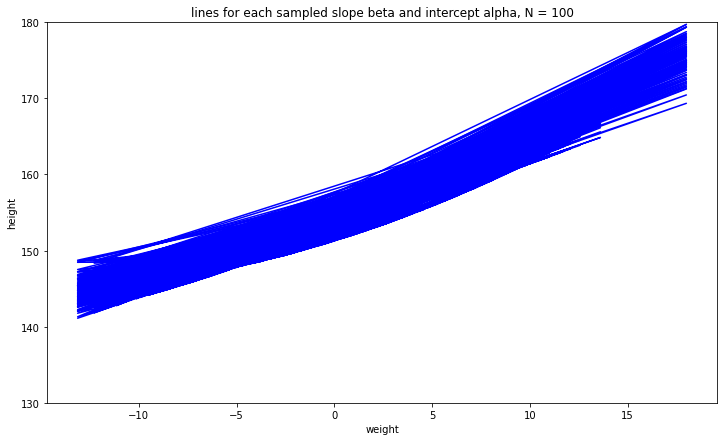

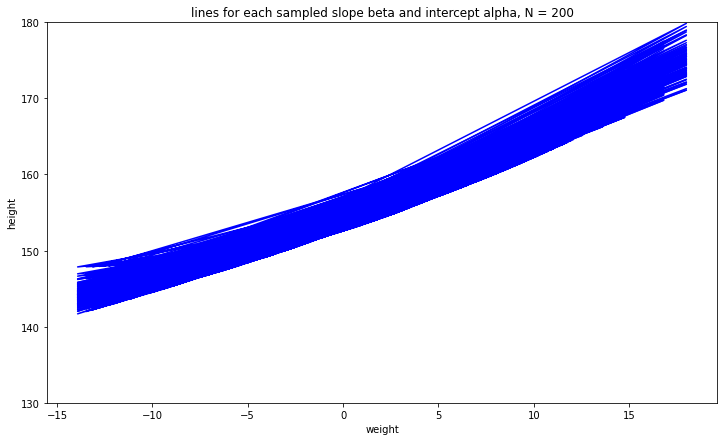

In [32]:
Ns = [10, 50, 100, 200]

for N in Ns:
    d_N = d.head(N)
    data_fit = dict(N=len(d_N),
                    weight = d_N.c_weight.values,
                    heights = d_N.height.values)

    fit=model_2_fit7.sample(data=data_fit,seed=28052020)

    alpha_fit = fit.stan_variable('alpha')
    beta_0_fit = fit.stan_variable('beta_0')
    beta_1_fit = fit.stan_variable('beta_1')
    mu_fit = fit.stan_variable('mu')
    height_pred = fit.stan_variable('height')

    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    for i in range(100):
        axs.plot(d_N.c_weight, alpha_fit[i] + beta_0_fit[i] * d_N.c_weight + beta_1_fit[i] * np.power(d_N.c_weight, 2), color='blue')
        axs.set_title(f"lines for each sampled slope beta and intercept alpha, N = {N}")
        axs.set_xlabel("weight")
        axs.set_ylabel("height")
        axs.set_ylim([130, 180])

model still remains good